In [1]:
import sys,os
sys.path.append("..")
import django
django.setup()
from crawlers.models import *
import pandas as pd
import datetime
from components.price_feature import GetAdj
import numpy as np
from components.backend_api import DataFilter
import math

In [63]:
class Backtest(GetAdj):
    def __init__(self, start_date: str, strategy, model=StockPriceTW, price_choice='close_price',
                 market=None, fee_ratio=4 / 10000, tax_ratio=3 / 1000, benchmark='0050'):
        super().__init__(start_date, model, price_choice, market)
        self.strategy = strategy
        self.fee_ratio = fee_ratio
        self.tax_ratio = tax_ratio
        self.benchmark = benchmark

    def get_backtest_data(self):
        backtest_data = GetAdj(self.start_date).normal_date_mode()
        backtest_data = backtest_data.reindex(self.strategy.index)
        return backtest_data

    def period_return(self, num, backtest_data, strategy):
        backtest_shift = backtest_data.shift(1)
        return_table = (backtest_data * (1 - self.fee_ratio) - (
                backtest_shift * (self.fee_ratio + self.tax_ratio))) / backtest_shift
        return_table = return_table.dropna(how='all')

        current_select = strategy.iloc[num].dropna()
        current_select = current_select[current_select]
        current_idx = current_select.index
        result = return_table[current_idx].iloc[num].mean()
        data = {'result': result, 'nstock': len(current_idx)}
        return data

    @staticmethod
    def max_drawdown(arr):
        i = np.argmax((np.maximum.accumulate(arr) - arr) / np.maximum.accumulate(arr))  # end of the period
        j = np.argmax(arr[:i])  # start of period
        data = {'max_drawdown': (1 - arr[i] / arr[j]), 'start': j, 'end': i}
        return data

    def report(self):
        backtest_data = self.get_backtest_data()
        report = {}
        benchmark = backtest_data[self.benchmark]
        benchmark_shift = benchmark.shift(1)
        report['benchmark'] = (benchmark / benchmark_shift).fillna(1)
        report['date'] = backtest_data.index
        backtest_info = [self.period_return(i, backtest_data, self.strategy) for i in range(len(self.strategy) - 1)]
        report['result'] = np.array([1] + [i['result'] for i in backtest_info])
        report['nstock'] = np.array([0] + [i['nstock'] for i in backtest_info])
        for m, i in enumerate(report['result']):
            if np.isnan(i):
                report['result'][m] = report['result'][m - 1]
        report['cumprod_result'] = report['result'].cumprod()
        max_drawdown = self.max_drawdown(report['cumprod_result'])
        report['max_drawdown'] = max_drawdown['max_drawdown']
        max_drawdown_period = [max_drawdown['start'], max_drawdown['end']]
        report['max_drawdown_period'] = [report['date'][i] for i in max_drawdown_period]
        report['annual_return'] = math.pow(report['cumprod_result'][-1], 12 / (len(report['date'])))
        return report

    def plot(self):
        df = self.report()
        df['benchmark'].cumprod().plot()
        pd.Series(df['cumprod_result'], index=df['date']).plot()

# Strategy

In [53]:
rev_data=DataFilter(model=MonthlyRevenueTW,fields=['stock_id','date','this_month_rev','cp_last_year_rev','cm_this_month_rev'],start_date='2012-01-10').get_pivot()
cp_last_year_rev=rev_data['cp_last_year_rev']
cp_last_year_rev.index = pd.to_datetime(cp_last_year_rev.index).shift(5, "d")
cp_last_year_rev

# rev = data.get('當月營收', 36)
# rev2 = data.get('當月營收', 60)
# revg = data.get('去年同月增減(%)', 36)#=revg2=(rev-rev.shift(12))/rev.shift(12)
# revg1 = data.get('前期比較增減(%)', 36)
# revgm=(rev-rev.shift(1))/(rev.shift(1))*100
# rev3=rev2.rolling(3, min_periods=3).mean()#近3月平均營收
# rev3_1=rev3.iloc[-36:]
# rev12=rev2.rolling(12, min_periods=12).mean()#近12月平均營收
# rev12_1=rev12.iloc[-36:]

# revg3=round((rev3-rev3.shift(12))/(rev3.shift(12))*100,2)#近3月平均營收年增率
# revg3=revg3.iloc[-36:]
# revg12=round((rev12-rev12.shift(12))/(rev12.shift(12))*100,2)#近12月平均營收年增率
# revg12=revg12.iloc[-36:]

stock_id,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9946,9949,9950,9951,9955,9957,9958,9960,9961,9962
date,,,,,,,,,,,,,,,,,,,,,
2012-01-15,-4.53,-4.29,-58.71,-4.99,6.93,18.97,16.32,4.81,-1.41,1.91,...,-49.05,29.92,-22.40,6.53,-33.85,-20.04,16.79,11.39,22.81,-14.40
2012-02-15,-25.05,-2.40,-61.63,-30.31,-22.01,-13.29,-9.52,0.45,-5.10,-9.26,...,365.70,-2.26,-13.68,-36.04,-2.57,-37.37,67.65,-7.21,-20.06,-0.93
2012-03-15,22.10,19.27,-3.56,40.97,45.06,75.07,46.89,14.00,-3.03,10.77,...,223.03,17.64,61.73,40.91,42.21,-14.60,135.39,0.13,-4.42,-16.97
2012-04-15,0.33,26.10,-25.62,7.34,7.01,32.65,-0.17,13.65,-11.76,1.33,...,46.64,10.76,-1.72,2.82,17.23,-28.55,-25.89,1.01,14.00,-23.85
2012-05-15,-4.92,14.09,42.82,3.25,-16.81,16.63,-3.21,7.49,-10.96,-4.62,...,-25.19,1.02,-8.58,4.99,7.78,-34.76,-6.78,-3.35,4.90,-18.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,-1.66,-9.94,39.06,52.99,132.22,33.21,39.00,-18.40,21.83,20.71,...,-64.65,-57.08,-34.17,-14.34,6.07,3.99,283.49,-11.39,NaN,13.27
2020-04-15,-12.90,-38.96,7.55,9.73,33.51,-9.78,-0.95,-10.92,14.83,7.83,...,-36.17,-44.14,-41.68,-47.01,-5.02,-16.90,114.50,-5.71,NaN,-11.07
2020-05-15,-3.58,-19.95,-1.20,14.84,24.81,2.58,23.33,-13.12,2.59,-3.79,...,-77.26,-48.95,-88.26,-53.25,-2.81,-19.67,179.98,5.38,NaN,-7.77


In [54]:
rev=rev_data['this_month_rev']
rev.index = pd.to_datetime(rev.index).shift(5, "d")
rev3=rev.rolling(3, min_periods=3).mean()
rev12=rev.rolling(12, min_periods=12).mean()
revg3=round((rev3-rev3.shift(12))/(rev3.shift(12))*100,2)#近3月平均營收年增率
revg12=round((rev12-rev12.shift(12))/(rev12.shift(12))*100,2)#近12月平均營收年增率
revg12

stock_id,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9946,9949,9950,9951,9955,9957,9958,9960,9961,9962
date,,,,,,,,,,,,,,,,,,,,,
2012-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,-3.07,3.22,-7.98,4.73,16.89,11.91,-8.12,-0.13,6.66,7.80,...,63.23,-12.51,20.85,-7.47,-21.27,-10.40,80.78,-15.59,NaN,-17.32
2020-04-15,-5.05,-2.89,-7.08,5.62,20.10,8.94,-7.43,-2.08,7.75,6.88,...,48.85,-15.12,14.84,-12.31,-22.20,-11.78,93.86,-15.06,NaN,-17.40
2020-05-15,-5.03,-6.23,-6.72,6.17,20.94,6.07,-5.82,-4.13,8.19,5.32,...,18.60,-17.15,-0.12,-16.87,-18.77,-10.44,106.19,-11.46,NaN,-18.13


In [55]:
cond1=rev3>rev12

In [56]:
cond2=cp_last_year_rev>30

In [57]:
data=[]
date_set=cp_last_year_rev.index[3:]
for i in range(3,len(cp_last_year_rev)):
    dgg=(cp_last_year_rev.iloc[i-3:i]>20).sum()==3
    data.append(dgg)
cond3=pd.DataFrame(data,date_set)

In [58]:
df=DataFilter(model=StockPriceTW,fields=['stock_id','date','close_price'],start_date='2013-01-10',market=['sii', 'otc']).get_pivot()
start_date=df.index[0]
last_date = df.index[-1]
date_range = pd.date_range(start=start_date, end=last_date)
df = df.reindex(date_range).fillna(method='ffill').dropna(how='all')
df2=df.reindex(cond1.index)
cond4=(df2>0)&(df2<=200)
cond4

stock_id,0015,0050,0051,0052,0053,0054,0055,0056,0057,0058,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
date,,,,,,,,,,,,,,,,,,,,,
2013-01-15,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2013-02-15,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2013-03-15,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2013-04-15,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2013-05-15,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2020-04-15,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2020-05-15,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [59]:

strategy=(cond1&cond2&cond3&cond4)
strategy

stock_id,0015,0050,0051,0052,0053,0054,0055,0056,0057,0058,...,9946,9949,9950,9951,9955,9957,9958,9960,9961,9962
date,,,,,,,,,,,,,,,,,,,,,
2012-01-15,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,NaN,False,False,NaN,False
2012-02-15,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,NaN,False,False,NaN,False
2012-03-15,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,NaN,False,False,NaN,False
2012-04-15,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,NaN,False,False,NaN,False
2012-05-15,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,NaN,False,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,NaN,True,False,NaN,False
2020-04-15,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,NaN,True,False,NaN,False
2020-05-15,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,NaN,True,False,NaN,False


In [64]:
df=Backtest(start_date='2012-01-10',strategy=strategy)
df=df.report()
df

{'benchmark': date
 2012-01-15    1.000000
 2012-02-15    1.075814
 2012-03-15    1.009856
 2012-04-15    0.965664
 2012-05-15    0.945247
                 ...   
 2020-03-15    0.867688
 2020-04-15    0.998668
 2020-05-15    1.028822
 2020-06-15    1.033752
 2020-07-15    1.111671
 Name: 0050, Length: 103, dtype: float64,
 'date': DatetimeIndex(['2012-01-15', '2012-02-15', '2012-03-15', '2012-04-15',
                '2012-05-15', '2012-06-15', '2012-07-15', '2012-08-15',
                '2012-09-15', '2012-10-15',
                ...
                '2019-10-15', '2019-11-15', '2019-12-15', '2020-01-15',
                '2020-02-15', '2020-03-15', '2020-04-15', '2020-05-15',
                '2020-06-15', '2020-07-15'],
               dtype='datetime64[ns]', name='date', length=103, freq=None),
 'result': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.00

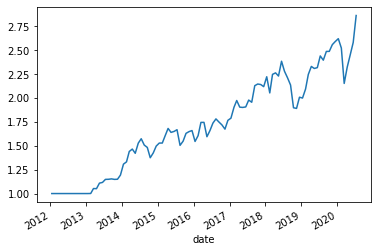

In [62]:
df2=pd.Series(df['cumprod_result'],df['date']).plot()
df2
